In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm

In [2]:
num_nodes = 196591  # number of graph nodes (users)
num_edges = 950327  # number of graph edges (connections)
num_check_ins = 6442890  # check-ins

### Data preprocessing

In [3]:
edge_list = []  # list of all connections
nodes = set()  # set of all users
s_list = []  # similarity array (without self-similarity)
with open('Gowalla_edges.txt', 'r') as f:
    for line in f:
        line = line.rstrip()
        user_1, user_2 = line.split()
        # fill the edges list with connections (user_1 is friends with user_2)
        edge_list.append((int(user_1), int(user_2)))
        nodes.add((int(user_1)))
        # mark each friendship as 1 plus some noise in similarity
        s_list.append(1)
        
# add "self to self" connections, their indexes start from num_edges * 2
for node in nodes:
    edge_list.append((node, node))

s_array = np.array(s_list, dtype=np.int8)

### Clusterization

Define necessary functions

In [4]:
def affinity_propagation(s, edges, max_iters, self_similarity_val):
    # form self-similarity array
    self_s = np.full(num_nodes, self_similarity_val)
    # form full similarity array (self-similarity values will start at index num_edges * 2)
    similarity = np.append(s, self_s)
    # initialise availability и responsibility with zeros
    responsibility = np.zeros(similarity.shape[0])
    availability = np.zeros(similarity.shape[0])
    
    for j in tqdm(range(max_iters)):
        # update responsibility
        responsibility = update_responsibility(similarity, availability, edges)
        # update availability
        availability = update_availability(availability, responsibility, edges)
    # get cluster exmplars for each user
    exemplars = get_exemplars(availability, responsibility, edge_list)
    
    return exemplars

In [5]:
def update_responsibility(S, A, edges):
    max_1 = np.full(num_nodes, -np.inf)
    max_2 = np.full(num_nodes, -np.inf)
    max_users = np.full(num_nodes, np.inf)
    # sum similarity and availability
    S_A = S + A
    # iterate over edges list
    for i, (user_1, user_2) in enumerate(edges):
        # find 2 highest values of s(i, j) + a(i, j) for each user
        if max_1[user_1] < S_A[i]:
            max_2[user_1] = max_1[user_1]
            max_1[user_1] = S_A[i]
            # remember user_2 that maximum value of s(i, j) + a(i, j) with user_1
            max_users[user_1] = user_2
        elif max_2[user_1] < S_A[i]:
            max_2[user_1] = S_A[i]
    # Copy S into R
    R = S.copy()

    # Now subtract either max_1 or max_2 depending on the max_users
    for i, (user_1, user_2) in enumerate(edges):
        if max_users[user_1] == user_2:
            R[i] -= max_2[user_1]
        else:
            R[i] -= max_1[user_1]
    
    return R

In [6]:
def update_availability(A, R, edges):
    # prepare for max(0, r(j, n)) part of the formula
    # we are not modifying self-r values here
    R_copy = R.copy()
    for i in range(num_edges * 2):
        if R_copy[i] < 0:
            R_copy[i] = 0
    # now we are making the sum of max(0, r(j, n))
    positive_r = np.zeros(num_nodes)
    for idx, (user_1, user_2) in enumerate(edges):
        positive_r[user_2] += R_copy[idx]
    # update availability
    for idx, (user_1, user_2) in enumerate(edges):
        # for indexes lesser than num_edges*2 subtract r(i, n) summed before,
        # r(n, n) wasn't summed (indexes lesser than num_edges*2);
        # for indexes greater tan num_edges*2 subtract r(n, n) summed before;
        A[idx] = positive_r[user_2] - R_copy[idx]

    # the min part of a(i, n) where i != n
    for i in range(num_edges * 2):
        A[i] = np.min([0, A[i]])
    
    return A

In [7]:
def get_exemplars(A, R, edges):
    temp = np.full(num_nodes, -np.inf)
    exemplars = dict()
    # sum availability and responsibility
    sum_a_r = A + R
    # for each user_1 find user_2 with maximum a(i, j) + r(i, j)
    for i, (user_1, user_2) in enumerate(edges):
        if sum_a_r[i] > temp[user_1]:
            temp[user_1] = sum_a_r[i]
            exemplars[user_1] = user_2
    
    return exemplars

Run algorithm

In [8]:
exemplars_ = affinity_propagation(s_array, edge_list, 10, -1.4)

100%|██████████| 10/10 [02:58<00:00, 17.84s/it]


In [9]:
len(set(exemplars_.values()))  # Number of clusters

47628

A little bit of analysis

In [10]:
# Get sizes of each cluster
clusters_lens = dict()
for exemplar in exemplars_.values():
    if exemplar not in clusters_lens:
        clusters_lens[exemplar] = 1
    else:
        clusters_lens[exemplar] += 1

In [11]:
max(clusters_lens.values())

9277

In [12]:
min(clusters_lens.values())

1

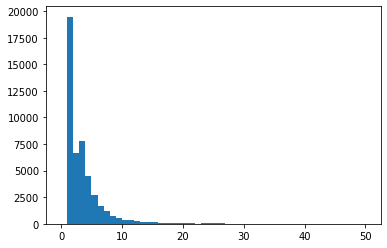

In [13]:
%matplotlib inline
plt.hist(clusters_lens.values(), bins=50, range=(0, 50))
plt.show()

### Evaluate results

Load all check-ins

In [14]:
check_ins_list = []
with open('Gowalla_totalCheckins.txt', 'r') as f:
    for line in f:
        line = line.rstrip()
        list_str = line.split()
        user = int(list_str[0])
        place = int(list_str[-1])
        check_ins_list.append((user, place))

# Shuffle check-ins
shuffle(check_ins_list)

In [15]:
len(set(map(lambda x: x[0], check_ins_list)))  # number of users that have checked in

107092

Create train and test sets

In [16]:
users_test = set()
users_train = set()
for check_in in check_ins_list:
    user = check_in[0]
    if len(users_test) < 10000:
        users_test.add(user)
    elif user not in users_test:
        users_train.add(user)

В качестве baseline возьмем гипотезу о том, что все пользователи находятся в 1 кластере. Мерить качество будем мерить метрикой precision@10. На тренеровочной выборке определим 10 локаций с самым большим числом чекинов.

First up, a naive approach. Simply recommend top-10 overall places.

In [17]:
places = dict()
for (user, place) in check_ins_list:
    if user in users_train:
        if place not in places.keys():
            places[place] = 1
        else:
            places[place] += 1

Find top-10 locations

In [18]:
places = [[k, v] for k, v in sorted(places.items(), key=lambda item: item[1], reverse=True)]
n = 10
top_n_places = [place[0] for place in places[:n]]
top_n_places

[55033, 19542, 9410, 10259, 58725, 66171, 9246, 10190, 14470, 23256]

Здесь для ясности сбиваюсь на русский. 
Насколько я понял, считать метрику для оценки результатов работы предсказаний надо считать так:
1. Если настоящее место есть в списке из n (в нашем случае 10) предсказанных, то засчитаем совпадение (match, матч)
2. Суммируем все матчи
3. Делим их на n
4. Агрегируем данные по всем пользователям (берём среднее)

In [19]:
matches = 0
for (user, place) in check_ins_list:
    if user in users_test:
        if place in top_n_places:
            matches += 1
metrics_naive = matches / (n * len(users_test))

In [20]:
metrics_naive

0.12523

Now lets use our clusters. We need to find all places visited by users in the clusters.

In [21]:
places_by_cluster = dict()
for (user, place) in check_ins_list:
    if user in users_train:
        exemplar = exemplars_[user]
        if exemplar not in places_by_cluster.keys():
            places_by_cluster[exemplar] = dict()
        else:
            if place not in places_by_cluster[exemplar].keys():
                places_by_cluster[exemplar][place] = 1
            else:
                places_by_cluster[exemplar][place] += 1

Now we sort locations and find top-10 of them.

In [22]:
top_n_places_for_clusters = dict()
for exemplar in places_by_cluster:
    places_by_cluster[exemplar] = [[k, v] for k, v in sorted(places_by_cluster[exemplar].items(), key=lambda item: item[1], reverse=True)]
for exemplar in places_by_cluster:
    top_n_places_for_clusters[exemplar] = [place[0] for place in places_by_cluster[exemplar][:n]]

In [23]:
top_n_places_for_clusters[0]

[420315, 21714, 19542, 9410, 8947, 182310, 9246, 9241, 32308, 10740]

Calculate metrics.

In [24]:
matches = 0
m = 0
for (user, place) in check_ins_list:
    if user in users_test:
        exemplar = exemplars_[user]
        m += 1
        if exemplar in top_n_places_for_clusters and place in top_n_places_for_clusters[exemplar]:
            matches += 1
metrics_cluster = matches / (len(users_test) * 10)

In [25]:
metrics_cluster

0.51933

### Conclusion
All in all, we've seen metrics uplift to 0.51 vs 0.13 with the naive approach. Some info:

Number of iterations: 10

Self-similarity: -1.4

Number of clusters: 47628

Largest cluster size: 9277

Smallest cluster size: 1